In [1]:
import os

os.chdir("..")

In [22]:
import random
import torch
import numpy as np
import torchvision.transforms as T
from PIL import Image

from src.models import simmim
from src.pretrain.data import MaskGenerator
from src.datasets import SWED

from src.datasets.utils import get_inverse_normalize


def percentile_normalization(
    img1: np.ndarray,
    img2: np.ndarray,
    lower: float = 2,
    upper: float = 98,
    axis=None,
) -> tuple[np.ndarray, np.ndarray]:
    assert lower < upper
    lower_percentile = np.percentile(img1, lower, axis=axis)
    upper_percentile = np.percentile(img1, upper, axis=axis)
    img1_normalized = np.clip(
        (img1 - lower_percentile) / (upper_percentile - lower_percentile + 1e-5), 0, 1
    )
    img2_normalized = np.clip(
        (img2 - lower_percentile) / (upper_percentile - lower_percentile + 1e-5), 0, 1
    )
    return img1_normalized, img2_normalized


def plot_reconstruction(
    model,
    image: torch.Tensor,
    mask_generator: MaskGenerator,
    transforms: T.Compose,
    denorm: T.Compose | None = None,
):
    if denorm is None:
        denorm = get_inverse_normalize(transforms.transforms)

    mask = torch.from_numpy(mask_generator()).unsqueeze(dim=0)
    x_rec, mask = model.reconstruct(x=transforms(image).unsqueeze(dim=0), mask=mask)
    mask = mask.squeeze().detach().cpu().numpy()
    x_rec = x_rec[0].detach().cpu()
    x_rec = denorm(x_rec).clip(0, 1) * 10000
    img = image.numpy().transpose(1, 2, 0)
    x_rec = x_rec.numpy().transpose(1, 2, 0)
    img, x_rec = percentile_normalization(
        img1=img, img2=x_rec, lower=2, upper=98, axis=(0, 1)
    )
    mask = Image.fromarray((mask * 255).astype(np.uint8))
    img = Image.fromarray((img[..., (3, 2, 1)] * 255).astype(np.uint8))
    recon = Image.fromarray((x_rec[..., (3, 2, 1)] * 255).astype(np.uint8))
    return img, Image.composite(recon, img, mask)


dataset = SWED(root="benchmark-datasets/SWED/", split="test")
config_path = "checkpoints/swin-v2-msi/config.yaml"
model, transforms, config = simmim(config_path)
mask_generator = MaskGenerator(
    input_size=config.DATA.IMG_SIZE,
    mask_patch_size=config.DATA.MASK_PATCH_SIZE,
    model_patch_size=config.MODEL.SWINV2.PATCH_SIZE,
    mask_ratio=0.6,
)
denorm = get_inverse_normalize(transforms.transforms)

=> merge config from checkpoints/swin-v2-msi/config.yaml


INFO:root:>>>>>>>>>> Resuming from checkpoints/swin-v2-msi/ckpt_epoch_799.pth ..........
INFO:root:<All keys matched successfully>
INFO:root:=> loaded successfully 'checkpoints/swin-v2-msi/ckpt_epoch_799.pth' (epoch 799)


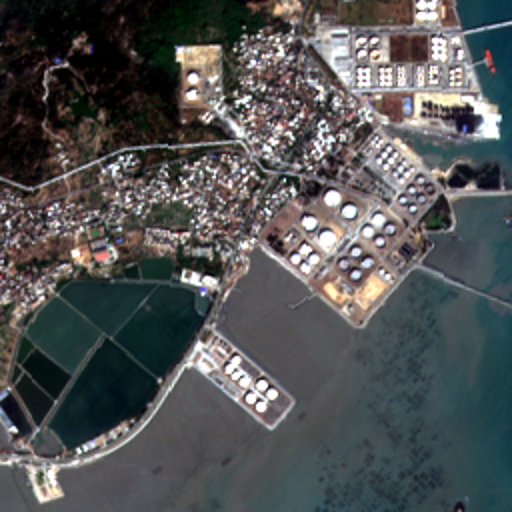

In [37]:
idx = random.randint(0, len(dataset))
image = dataset[idx]["image"]
img, recon = plot_reconstruction(model, image, mask_generator, transforms, denorm)
img.resize((512, 512))

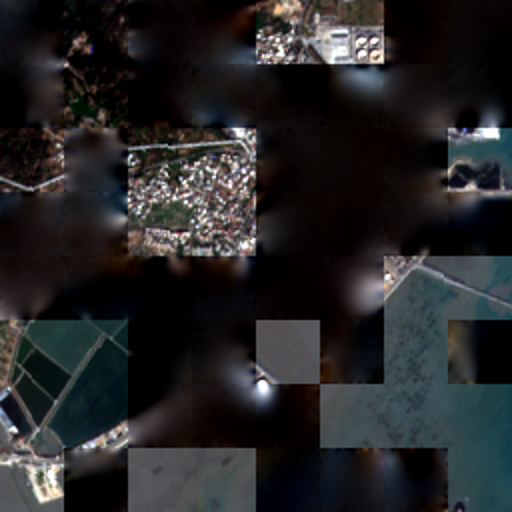

In [38]:
recon.resize((512, 512))